In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import T5Tokenizer, T5EncoderModel
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import json
import matplotlib.pyplot as plt
# Load tokenizer and pre-trained text encoder
tokenizer = T5Tokenizer.from_pretrained("t5-small")
text_encoder = T5EncoderModel.from_pretrained("t5-small")

In [2]:
import os

img_dir = '/kaggle/input/train-dataset/train2017'  # Update this to your dataset path

# List all files in the folder and filter out the non-JPG files
image_files = [file for file in os.listdir(img_dir) if file.endswith('.jpg')]

# Print the filenames of the images
# for filename in image_files:
#     print(filename)

# Optionally, print the total number of image files
print(f"Total number of images: {len(image_files)}")


Total number of images: 7000


In [2]:


# Define Conditional VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, condition_dim, img_size):
        super(ConditionalVAE, self).__init__()
        self.img_size = img_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * (img_size // 4) * (img_size // 4), latent_dim)
        self.fc_logvar = nn.Linear(128 * (img_size // 4) * (img_size // 4), latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + condition_dim, 128 * (img_size // 4) * (img_size // 4))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, condition):
        z_cond = torch.cat([z, condition], dim=1)
        h = self.decoder_input(z_cond)
        h = h.view(h.size(0), 128, self.img_size // 4, self.img_size // 4)
        return self.decoder(h)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, condition)
        return recon, mu, logvar

# Gated Fusion
class GatedFusion(nn.Module):
    def __init__(self, text_dim, image_dim, fusion_dim):
        super(GatedFusion, self).__init__()
        self.gate = nn.Linear(text_dim + image_dim, fusion_dim)
        self.fc = nn.Linear(text_dim + image_dim, fusion_dim)

    def forward(self, text_features, img_features):
        combined = torch.cat([text_features, img_features], dim=1)
        gate = torch.sigmoid(self.gate(combined))
        fused = gate * self.fc(combined)
        return fused

# Improved Dataset class
class COCODataset(Dataset):
    def __init__(self, img_dir, ann_file, transform):
        self.img_dir = img_dir
        self.transform = transform

        # Preprocess annotations
        with open(ann_file, 'r') as f:
            annotations = json.load(f)['annotations']

        # Prepare image filenames from the directory (no need to extract IDs directly)
        image_files = [file.split('.')[0] for file in os.listdir(img_dir) if file.endswith('.jpg')]

        # Prepare image IDs and captions
        self.img_ids = []
        self.captions = []

        # Track and filter valid images
        for ann in annotations:
            img_id = f"{ann['image_id']:012}"  # Format image_id to 12 digits
            if img_id in image_files:  # Only append if the image is in the directory
                self.img_ids.append(img_id)
                self.captions.append(ann['caption'])

        print(f"Total valid images in dataset: {len(self.img_ids)}")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        try:
            img_id = self.img_ids[idx]
            caption = self.captions[idx]
            img_path = os.path.join(self.img_dir, f"{img_id}.jpg")

            # Open and validate image
            image = Image.open(img_path).convert('RGB')
            if image.size[0] == 0 or image.size[1] == 0:
                print(f"Warning: Invalid image size at index {idx}")
                return None

            image = self.transform(image)
            return caption, image
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Custom collate function to handle potential None values
def custom_collate(batch):
    # Filter out None values
    batch = list(filter(lambda x: x is not None, batch))

    if len(batch) == 0:
        return None, None

    # Separate captions and images
    captions, images = zip(*batch)

    # Convert to tensors
    images = torch.stack(images)

    return captions, images

# Data loaders with improvements
train_dataset = COCODataset("/kaggle/input/train-dataset/train2017", "/kaggle/input/coco-ann2017/annotations/captions_train2017.json", transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,  # Use multiple workers for data loading
    pin_memory=True,
    collate_fn=custom_collate
)

# Define models and optimizer
text_dim = text_encoder.config.hidden_size
latent_dim = 128
fusion_dim = 256
img_size = 128

conditional_vae = ConditionalVAE(latent_dim, text_dim, img_size)
gated_fusion = GatedFusion(text_dim, latent_dim, fusion_dim)
optimizer = optim.Adam(list(conditional_vae.parameters()) + list(gated_fusion.parameters()), lr=1e-4)



Total valid images in dataset: 35020


In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train(epoch, text_encoder, train_loader, conditional_vae, gated_fusion, optimizer, checkpoint_dir='./checkpoints'):
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Print epoch start information
    print(f"Starting epoch {epoch}")
    print(f"Total batches in loader: {len(train_loader)}")
    
    # Move models to device
    text_encoder = text_encoder.to(device)
    conditional_vae = conditional_vae.to(device)
    gated_fusion = gated_fusion.to(device)
    
    # Set models to train mode
    text_encoder.eval()  # Pretrained text encoder is frozen
    conditional_vae.train()
    gated_fusion.train()
    
    # Epoch-level loss tracking
    total_loss = 0.0
    batch_count = 0
    global_batch_count = 0
    
    # Training loop
    for batch_idx, batch in enumerate(train_loader):
        # Check for empty batch
        if batch is None or batch[0] is None:
            print(f"Skipping empty batch at index {batch_idx}")
            continue
        
        # Unpack batch
        captions, images = batch
        
        # Move data to device
        images = images.to(device)
        
        # Tokenize captions
        tokens = tokenizer(captions, padding=True, return_tensors="pt")
        input_ids = tokens.input_ids.to(device)
        attention_mask = tokens.attention_mask.to(device)
        
        # Extract text features
        with torch.no_grad():
            text_features = text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.mean(dim=1)
        
        # Conditional VAE forward pass
        recon, mu, logvar = conditional_vae(images, text_features)
        
        # Gated fusion
        fused_features = gated_fusion(text_features, mu)
        
        # Compute loss (reconstruction + KL divergence)
        recon_loss = nn.MSELoss()(recon, images)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kld_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss tracking
        total_loss += loss.item()
        batch_count += 1
        global_batch_count += 1
        
        # Logging
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} Batch {batch_idx} Loss: {loss.item():.4f}")
        

    
    # Epoch summary
    avg_loss = total_loss / batch_count if batch_count > 0 else 0
    print(f"Epoch {epoch} Complete - Average Loss: {avg_loss:.4f}")
    if epoch % 20 == 0:
        # Prepare checkpoint
        checkpoint = {
            'epoch': epoch,
            'conditional_vae_state_dict': conditional_vae.state_dict(),
            'gated_fusion_state_dict': gated_fusion.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        
        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch{epoch}.pth')
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")
    
    return global_batch_count

# Optional: Checkpoint loading if you want to resume training
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Resume from last checkpoint if exists
start_epoch = 0
global_batch_count = 0
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]

if checkpoint_files:
    # Get the latest checkpoint
    latest_checkpoint = 'checkpoint_epoch40.pth'
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Restore model states
    conditional_vae.load_state_dict(checkpoint['conditional_vae_state_dict'])
    gated_fusion.load_state_dict(checkpoint['gated_fusion_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Restore training state
    start_epoch = checkpoint['epoch']
    
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    print(f"Starting from epoch {start_epoch}")

# Modify model instantiation to support device
text_dim = text_encoder.config.hidden_size
latent_dim = 128
fusion_dim = 256
img_size = 128

conditional_vae = ConditionalVAE(latent_dim, text_dim, img_size).to(device)
gated_fusion = GatedFusion(text_dim, latent_dim, fusion_dim).to(device)
optimizer = optim.Adam(list(conditional_vae.parameters()) + list(gated_fusion.parameters()), lr=1e-4)

# Train the model
for epoch in range(start_epoch, 120):  # Modify range as needed
    global_batch_count = train(
        epoch, 
        text_encoder, 
        train_loader, 
        conditional_vae, 
        gated_fusion, 
        optimizer,
        checkpoint_dir
    )



Using device: cuda


/tmp/ipykernel_23/404746244.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Resuming from checkpoint: checkpoint_epoch40.pth
Starting from epoch 40
Starting epoch 40
Total batches in loader: 2189
Epoch 40 Batch 0 Loss: 3.9871
Epoch 40 Batch 100 Loss: 0.3115
Epoch 40 Batch 200 Loss: 0.3513
Epoch 40 Batch 300 Loss: 0.3310
Epoch 40 Batch 400 Loss: 0.3098
Epoch 40 Batch 500 Loss: 0.2916
Epoch 40 Batch 600 Loss: 0.3175
Epoch 40 Batch 700 Loss: 0.3015
Epoch 40 Batch 800 Loss: 0.2735
Epoch 40 Batch 900 Loss: 0.3237
Epoch 40 Batch 1000 Loss: 0.2754
Epoch 40 Batch 1100 Loss: 0.2708
Epoch 40 Batch 1200 Loss: 0.3179
Epoch 40 Batch 1300 Loss: 0.2616
Epoch 40 Batch 1400 Loss: 0.2974
Epoch 40 Batch 1500 Loss: 0.3178
Epoch 40 Batch 1600 Loss: 0.3115
Epoch 40 Batch 1700 Loss: 0.3128
Epoch 40 Batch 1800 Loss: 0.2711
Epoch 40 Batch 1900 Loss: 0.2843
Epoch 40 Batch 2000 Loss: 0.2862
Epoch 40 Batch 2100 Loss: 0.2587
Epoch 40 Complete - Average Loss: 0.6968
Saved checkpoint to ./checkpoints/checkpoint_epoch40.pth
Starting epoch 41
Total batches in loader: 2189
Epoch 41 Batch 0 Los

In [20]:
from IPython.display import FileLink
checkpoint_path = './checkpoints/checkpoint_epoch100.pth'
FileLink(checkpoint_path)

/kaggle/working/checkpoints/checkpoint_epoch100.pth

Using device: cuda


/tmp/ipykernel_23/898219884.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/epoch100/pytorch/default/1/checkpoint_epoch100.pth', 

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/generated_images/text_generation_0.png'

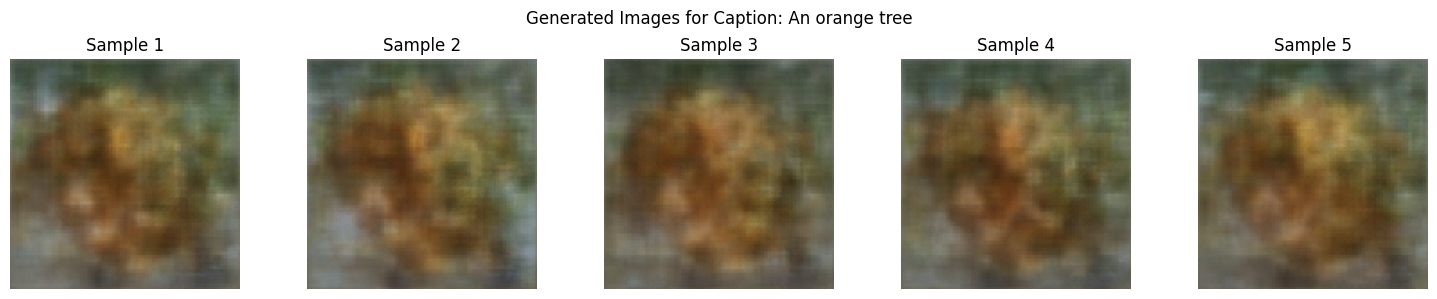

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# # Run testing
# test_model(text_encoder, conditional_vae, gated_fusion, test_loader)

# Optional: Generate images from specific text descriptions
def generate_from_text(text_encoder, conditional_vae, captions, num_samples=5):
    """
    Generate images from specific text descriptions
    
    Args:
    - text_encoder: Pretrained text encoder
    - conditional_vae: Conditional Variational Autoencoder
    - captions: List of text descriptions
    - num_samples: Number of images to generate per caption
    """
    # Set models to evaluation mode
    checkpoint = torch.load('/kaggle/input/epoch100/pytorch/default/1/checkpoint_epoch100.pth', map_location=device)
    text_encoder = text_encoder.to(device)
    conditional_vae = conditional_vae.to(device)
    # gated_fusion = gated_fusion.to(device)
    # Restore model states
    conditional_vae.load_state_dict(checkpoint['conditional_vae_state_dict'])
    gated_fusion.load_state_dict(checkpoint['gated_fusion_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    text_encoder.eval()
    conditional_vae.eval()
    
    with torch.no_grad():
        # Tokenize captions
        tokens = tokenizer(captions, padding=True, return_tensors="pt")
        input_ids = tokens.input_ids.to(device)
        attention_mask = tokens.attention_mask.to(device)
        
        # Extract text features
        text_features = text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.mean(dim=1)
        
        # Generate multiple samples for each caption
        for i, (caption, text_feat) in enumerate(zip(captions, text_features)):
            plt.figure(figsize=(15, 3))
            
            for j in range(num_samples):
                # Sample from the latent space
                z = torch.randn(1, latent_dim, device= device)
                
                # Generate image
                generated_image = conditional_vae.decode(z, text_feat.unsqueeze(0))
                
                # Denormalize the image
                img = generated_image[0].cpu()
                img = (img * 0.5) + 0.5  # Reverse normalization
                
                # Plot generated image
                plt.subplot(1, num_samples, j+1)
                plt.imshow(img.permute(1, 2, 0))
                plt.title(f"Sample {j+1}")
                plt.axis('off')
            
            plt.suptitle(f"Generated Images for Caption: {caption}")
            plt.tight_layout()
            plt.savefig(f'./generated_images/text_generation_{i}.png')
            plt.close()

# Example usage of text-specific generation
custom_captions = [
    "An orange tree",
    "A busy street in New York City"
]
generate_from_text(text_encoder, conditional_vae, custom_captions)